In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import platform
import random
import uuid
import os
import os.path
import skimage
import utils
import utils.wavelet
import utils.data
import utils.data.augmentation
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import networkx
import networkx.algorithms.approximation
import math
import wfdb
import json
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils.signal import StandardHeader
from scipy.stats import lognorm, norm, halfnorm

def trailonset(sig,on):
    on = on-sig[0]
    off = on-sig[0]+sig[-1]
    sig = sig+np.linspace(on,off,sig.size,dtype=sig.dtype)
    
    return sig

# Load files

In [3]:
Psignal = utils.pickleload(os.path.join('.','pickle','Psignal.pkl'))
PQsignal = utils.pickleload(os.path.join('.','pickle','PQsignal.pkl'))
QRSsignal = utils.pickleload(os.path.join('.','pickle','QRSsignal.pkl'))
STsignal = utils.pickleload(os.path.join('.','pickle','STsignal.pkl'))
Tsignal = utils.pickleload(os.path.join('.','pickle','Tsignal.pkl'))
TPsignal = utils.pickleload(os.path.join('.','pickle','TPsignal.pkl'))

In [4]:
for key in (['104_II','104_III','104_AVR','104_AVF','103_III'] + 
            ['74_{}'.format(h) for h in StandardHeader] + 
            ['111_{}'.format(h) for h in StandardHeader] +
            ['95_{}'.format(h) for h in StandardHeader] + 
            ['103_{}'.format(h) for h in StandardHeader] +
            ['34_{}'.format(h) for h in StandardHeader]):
    [Psignal.pop(k) for k in list(Psignal.keys()) if k.startswith('{}###'.format(key))]
    [PQsignal.pop(k) for k in list(PQsignal.keys()) if k.startswith('{}###'.format(key))]
    [QRSsignal.pop(k) for k in list(QRSsignal.keys()) if k.startswith('{}###'.format(key))]
    [STsignal.pop(k) for k in list(STsignal.keys()) if k.startswith('{}###'.format(key))]
    [Tsignal.pop(k) for k in list(Tsignal.keys()) if k.startswith('{}###'.format(key))]
    [TPsignal.pop(k) for k in list(TPsignal.keys()) if k.startswith('{}###'.format(key))]

In [5]:
for key in []: 
    if key in Psignal: Psignal.pop(key)
for key in []: 
    if key in PQsignal: PQsignal.pop(key)
for key in ['7_V2###0','7_V2###2','7_V2###4','95_V4###0','95_V4###1','95_V4###2']: 
    if key in QRSsignal: QRSsignal.pop(key)
for key in []: 
    if key in STsignal: STsignal.pop(key)
for key in []: 
    if key in Tsignal: Tsignal.pop(key)
for key in (['52_III###4','34_V6###6','74_V4###0','74_V4###1','74_V4###2',
             '74_V4###3','74_V4###4','74_V4###5','74_V4###6','74_V4###7',] + 
            ['111_V2###{}'.format(i) for i in range(7)]): 
    if key in TPsignal: TPsignal.pop(key)

# Normalize amplitudes

In [6]:
metric = np.max

amplitudes = {k.split('###')[0]: [] for k in list(QRSsignal)}
for k in QRSsignal:
    g = k.split('###')[0]
    segment = utils.signal.on_off_correction(QRSsignal[k])
    amplitudes[g].append(np.max(segment) - np.min(segment))

In [7]:
Pamplitudes = []
for k in Psignal:
    segment = utils.signal.on_off_correction(Psignal[k])/metric(amplitudes[k.split('###')[0]])
    Pamplitudes.append(segment.max()-segment.min())
Pamplitudes = np.array(Pamplitudes)
PQamplitudes = []
for k in PQsignal:
    segment = utils.signal.on_off_correction(PQsignal[k])/metric(amplitudes[k.split('###')[0]])
    PQamplitudes.append(segment.max()-segment.min())
PQamplitudes = np.array(PQamplitudes)
QRSamplitudes = []
for k in QRSsignal:
    segment = utils.signal.on_off_correction(QRSsignal[k])/metric(amplitudes[k.split('###')[0]])
    QRSamplitudes.append(segment.max()-segment.min())
QRSamplitudes = np.array(QRSamplitudes)
STamplitudes = []
for k in STsignal:
    segment = utils.signal.on_off_correction(STsignal[k])/metric(amplitudes[k.split('###')[0]])
    STamplitudes.append(segment.max()-segment.min())
STamplitudes = np.array(STamplitudes)
Tamplitudes = []
for k in Tsignal:
    segment = utils.signal.on_off_correction(Tsignal[k])/metric(amplitudes[k.split('###')[0]])
    Tamplitudes.append(segment.max()-segment.min())
Tamplitudes = np.array(Tamplitudes)
TPamplitudes = []
for k in TPsignal:
    segment = utils.signal.on_off_correction(TPsignal[k])/metric(amplitudes[k.split('###')[0]])
    TPamplitudes.append(segment.max()-segment.min())
TPamplitudes = np.array(TPamplitudes)

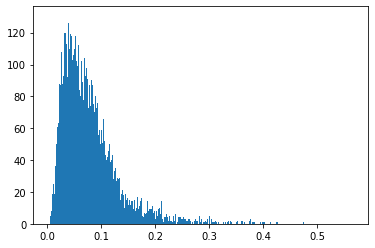

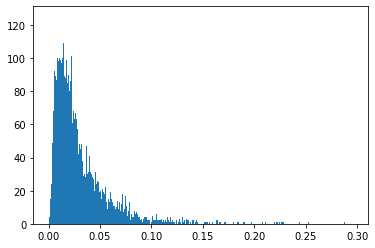

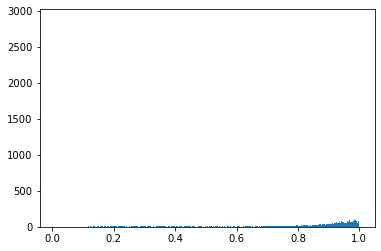

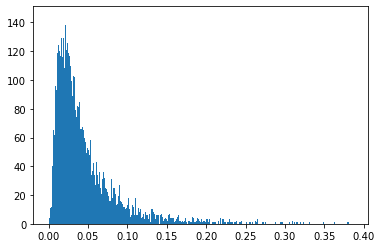

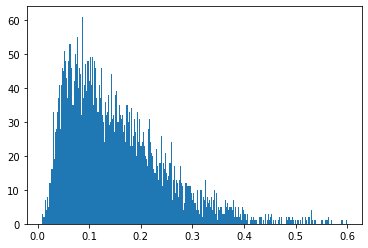

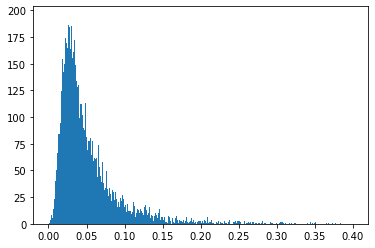

In [9]:
plt.figure()
_ = plt.hist(Pamplitudes,bins=1000)
plt.savefig('./Pamplitudes.svg')
plt.figure()
_ = plt.hist(PQamplitudes[PQamplitudes<0.3],bins=1000)
plt.savefig('./PQamplitudes.svg')
plt.figure()
_ = plt.hist(QRSamplitudes,bins=1000)
plt.savefig('./QRSamplitudes.svg')
plt.figure()
_ = plt.hist(STamplitudes[STamplitudes<0.4],bins=1000)
plt.savefig('./STamplitudes.svg')
plt.figure()
_ = plt.hist(Tamplitudes[Tamplitudes<0.6],bins=1000)
plt.savefig('./Tamplitudes.svg')
plt.figure()
_ = plt.hist(TPamplitudes[TPamplitudes<0.4],bins=1000)
plt.savefig('./TPamplitudes.svg')

In [10]:
# QRSamplitudes = QRSamplitudes[:QRSamplitudes.size//2]
# QRSamplitudes = np.concatenate((QRSamplitudes,2-QRSamplitudes))
Pdist = lognorm(*lognorm.fit(Pamplitudes))
PQdist = lognorm(*lognorm.fit(PQamplitudes[PQamplitudes<0.3]))
QRSdist = lognorm(*lognorm.fit(QRSamplitudes))
STdist = lognorm(*lognorm.fit(STamplitudes))
Tdist = lognorm(*lognorm.fit(Tamplitudes[(Tamplitudes>0.05) & (Tamplitudes<0.5)]))
TPdist = lognorm(*lognorm.fit(TPamplitudes[TPamplitudes<0.4]))

In [11]:
for k in list(Psignal.keys()):
    segment = utils.signal.on_off_correction(Psignal[k])
    Psignal[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(Psignal[k])) or np.any(np.isnan(Psignal[k])):
        Psignal.pop(k)
for k in list(PQsignal.keys()):
    segment = utils.signal.on_off_correction(PQsignal[k])
    PQsignal[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(PQsignal[k])) or np.any(np.isnan(PQsignal[k])):
        PQsignal.pop(k)
for k in list(QRSsignal.keys()):
    segment = utils.signal.on_off_correction(QRSsignal[k])
    QRSsignal[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(QRSsignal[k])) or np.any(np.isnan(QRSsignal[k])):
        QRSsignal.pop(k)
for k in list(STsignal.keys()):
    segment = utils.signal.on_off_correction(STsignal[k])
    STsignal[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(STsignal[k])) or np.any(np.isnan(STsignal[k])):
        STsignal.pop(k)
for k in list(Tsignal.keys()):
    segment = utils.signal.on_off_correction(Tsignal[k])
    Tsignal[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(Tsignal[k])) or np.any(np.isnan(Tsignal[k])):
        Tsignal.pop(k)
for k in list(TPsignal.keys()):
    segment = utils.signal.on_off_correction(TPsignal[k])
    TPsignal[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(TPsignal[k])) or np.any(np.isnan(TPsignal[k])):
        TPsignal.pop(k)

<ipython-input-11-4e060df72ca2>:8: RuntimeWarning: invalid value encountered in true_divide
  PQsignal[k] = segment/(np.max(segment)-np.min(segment))
<ipython-input-11-4e060df72ca2>:18: RuntimeWarning: invalid value encountered in true_divide
  STsignal[k] = segment/(np.max(segment)-np.min(segment))


# Mixup

In [45]:
# number = 1

# too_much_it_squares_amount_of_data

# permuted = np.random.permutation(list(Psignal))
# for k1 in tqdm.tqdm(list(Psignal.keys())):
#     visited = {}
#     (k_all_1,g_1) = Pgroup[k1]
#     counter = 0
#     for k2 in permuted:
#         (k_all_2,g_2) = Pgroup[k2]
#         if (k1 != k2) & (g_1 != g_2):
#             visited[g_2] = visited.get(g_2,0)+1
#             if visited[g_2] > number:
#                 continue
#             if Psignal[k1].size != Psignal[k2].size:
#                 intlen = np.random.randint(min([Psignal[k1].size,Psignal[k2].size]),max([Psignal[k1].size,Psignal[k2].size]))
#                 x1 = sp.interpolate.interp1d(np.linspace(0,1,Psignal[k1].size),Psignal[k1])(np.linspace(0,1,intlen))
#                 x2 = sp.interpolate.interp1d(np.linspace(0,1,Psignal[k2].size),Psignal[k2])(np.linspace(0,1,intlen))
#             else:
#                 x1 = Psignal[k1]
#                 x2 = Psignal[k2]
#             (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
#             Psignal[k1+'m'+str(counter)] = xhat.squeeze()
#             Pgroup[k1+'m'+str(counter)] = Pgroup[k1]
#             counter += 1

# permuted = np.random.permutation(list(QRSsignal))
# for k1 in tqdm.tqdm(list(QRSsignal.keys())):
#     visited = {}
#     (k_all_1,g_1) = QRSgroup[k1]
#     counter = 0
#     for k2 in permuted:
#         (k_all_2,g_2) = QRSgroup[k2]
#         if (k1 != k2) & (g_1 != g_2):
#             visited[g_2] = visited.get(g_2,0)+1
#             if visited[g_2] > number:
#                 continue
#             if QRSsignal[k1].size != QRSsignal[k2].size:
#                 intlen = np.random.randint(min([QRSsignal[k1].size,QRSsignal[k2].size]),max([QRSsignal[k1].size,QRSsignal[k2].size]))
#                 x1 = sp.interpolate.interp1d(np.linspace(0,1,QRSsignal[k1].size),QRSsignal[k1])(np.linspace(0,1,intlen))
#                 x2 = sp.interpolate.interp1d(np.linspace(0,1,QRSsignal[k2].size),QRSsignal[k2])(np.linspace(0,1,intlen))
#             else:
#                 x1 = QRSsignal[k1]
#                 x2 = QRSsignal[k2]
#             (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
#             QRSsignal[k1+'m'+str(counter)] = xhat.squeeze()
#             QRSgroup[k1+'m'+str(counter)] = QRSgroup[k1]
#             counter += 1

# permuted = np.random.permutation(list(Tsignal))
# for k1 in tqdm.tqdm(list(Tsignal.keys())):
#     visited = {}
#     (k_all_1,g_1) = Tgroup[k1]
#     counter = 0
#     for k2 in permuted:
#         (k_all_2,g_2) = Tgroup[k2]
#         if (k1 != k2) & (g_1 != g_2):
#             visited[g_2] = visited.get(g_2,0)+1
#             if visited[g_2] > number:
#                 continue
#             if Tsignal[k1].size != Tsignal[k2].size:
#                 intlen = np.random.randint(min([Tsignal[k1].size,Tsignal[k2].size]),max([Tsignal[k1].size,Tsignal[k2].size]))
#                 x1 = sp.interpolate.interp1d(np.linspace(0,1,Tsignal[k1].size),Tsignal[k1])(np.linspace(0,1,intlen))
#                 x2 = sp.interpolate.interp1d(np.linspace(0,1,Tsignal[k2].size),Tsignal[k2])(np.linspace(0,1,intlen))
#             else:
#                 x1 = Tsignal[k1]
#                 x2 = Tsignal[k2]
#             (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
#             Tsignal[k1+'m'+str(counter)] = xhat.squeeze()
#             Tgroup[k1+'m'+str(counter)] = Tgroup[k1]
#             counter += 1

In [46]:
# print(len(Psignal))
# print(len(PQsignal))
# print(len(QRSsignal))
# print(len(STsignal))
# print(len(Tsignal))
# print(len(TPsignal))

# Generate recording, probabilistic amplitudes

In [12]:
Pkeys = list(Psignal.keys())
PQkeys = list(PQsignal.keys())
QRSkeys = list(QRSsignal.keys())
STkeys = list(STsignal.keys())
Tkeys = list(Tsignal.keys())
TPkeys = list(TPsignal.keys())

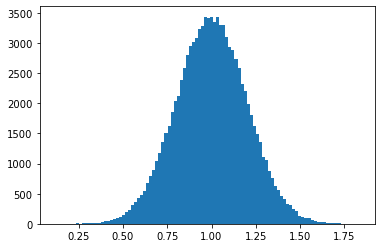

In [25]:
_=plt.hist(1.+(np.random.randn(100000)*0.2),bins=100)

In [277]:
%%timeit
np.random.randint(0,len(Psignal),size=size)

173 µs ± 910 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [279]:
%%timeit
np.random.randint(0,len(Psignal),size=500)

20 µs ± 975 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [352]:
%%timeit
N = 2048

# Hyperparams
noise = 0.005
size = 500
onset = np.random.randint(0,50)
begining_wave = np.random.randint(0,6)
global_amplitude = 1.+(np.random.randn(1)*0.2)
interp_length = 1.+(np.random.randn(1)*0.2)
has_P = (np.random.rand(1) > 0.35)
has_PQ = (np.random.rand(1) > 0.15)
has_ST = (np.random.rand(1) > 0.25)
has_BBB = (np.random.rand(1) > 0.9)
has_TV = (np.random.rand(1) > 0.0)
has_same_morph = (np.random.rand(1) > 0.5)
proba_P = 0.15
proba_PQ = 0.15
proba_QRS = 0.01
proba_ST = 0.15

##### Data structure
ids = []

##### Identifiers
if not has_same_morph:
    id_P = np.random.randint(0,len(Psignal),size=size)
    id_PQ = np.random.randint(0,len(PQsignal),size=size)
    id_QRS = np.random.randint(0,len(QRSsignal),size=size)
    id_ST = np.random.randint(0,len(STsignal),size=size)
    id_T = np.random.randint(0,len(Tsignal),size=size)
    id_TP = np.random.randint(0,len(TPsignal),size=size)
else:
    id_P = np.repeat(np.random.randint(0,len(Psignal),size=1),size)
    id_PQ = np.repeat(np.random.randint(0,len(PQsignal),size=1),size)
    id_QRS = np.repeat(np.random.randint(0,len(QRSsignal),size=1),size)
    id_ST = np.repeat(np.random.randint(0,len(STsignal),size=1),size)
    id_T = np.repeat(np.random.randint(0,len(Tsignal),size=1),size)
    id_TP = np.repeat(np.random.randint(0,len(TPsignal),size=1),size)
    
# In case QRS is not expressed
filt_QRS = np.random.rand(size) < proba_QRS

# Except waves
id_P[(np.random.rand(size) < proba_P) | np.logical_not(has_P) | has_TV] = -1
id_PQ[filt_QRS | (np.random.rand(size) < proba_PQ) | np.logical_not(has_PQ) | has_TV] = -1
id_QRS[filt_QRS] = -1
id_ST[filt_QRS | (np.random.rand(size) < proba_ST) | np.logical_not(has_ST) | has_TV] = -1
id_T[filt_QRS] = -1
id_TP[(np.full((size),False,dtype=bool)) | has_TV] = -1

beats = []
masks = []
ids = []
offset = 0
record_size = 0
mark_break = False
for i in range(size):
    for j in range(6):
        if (i == 0) and (j < begining_wave): 
            continue
        if (j == 0) and (id_P[i] != -1):
            amplitude = Pdist.rvs(1)
            segment = trailonset(amplitude*Psignal[Pkeys[id_P[i]]],offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.full((beats[-1].size,),1,dtype='int8'))
            ids.append(('P',Pkeys[id_P[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 1) and (id_PQ[i] != -1):
            amplitude = PQdist.rvs(1)
            segment = trailonset(amplitude*PQsignal[PQkeys[id_PQ[i]]],offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('PQ',PQkeys[id_PQ[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 2) and (id_QRS[i] != -1):
            amplitude = QRSdist.rvs(1)
#             amplitude = 0.15*np.random.randn(1)+1.05
            segment = trailonset(amplitude*QRSsignal[QRSkeys[id_QRS[i]]],offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.full((beats[-1].size,),2,dtype='int8'))
            ids.append(('QRS',QRSkeys[id_QRS[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 3) and (id_ST[i] != -1):
            amplitude = STdist.rvs(1)
            segment = trailonset(amplitude*STsignal[STkeys[id_ST[i]]],offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('ST',STkeys[id_ST[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 4) and (id_T[i] != -1):
            amplitude = Tdist.rvs(1)
            segment = trailonset(amplitude*Tsignal[Tkeys[id_T[i]]],offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.full((beats[-1].size,),3,dtype='int8'))
            ids.append(('T',Tkeys[id_T[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 5) and (id_TP[i] != -1):
            amplitude = TPdist.rvs(1)
            segment = trailonset(amplitude*TPsignal[TPkeys[id_TP[i]]],offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('TP',TPkeys[id_TP[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (math.floor(record_size*interp_length)-onset) >= N:
            mark_break = True
            break
    if mark_break:
        break
        
# Obtain final stuff
signal = np.concatenate(beats)
masks = np.concatenate(masks)

signal_pre = np.copy(signal)
masks_pre = np.copy(masks)

# Interpolate signal & mask
x = np.linspace(0,1,signal.size)
signal = sp.interpolate.interp1d(x,signal)(np.linspace(0,1,math.ceil(signal.size*interp_length)))
masks = sp.interpolate.interp1d(x,masks)(np.linspace(0,1,math.ceil(masks.size*interp_length))).astype(int)

# Move onset
signal = signal[onset:onset+N]*global_amplitude
masks = masks[onset:onset+N]

# Retrieve masks
masks_all = np.zeros((N,3),dtype=bool)
masks_all[:,0] = (masks == 1)
masks_all[:,1] = (masks == 2)
masks_all[:,2] = (masks == 3)

# Add baseline wander
w = 51
signal = signal + np.convolve(np.cumsum(norm.rvs(scale=0.01**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

# # Plotting
# mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

# plt.figure(figsize=(20,5))
# plt.plot(signal)
# plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
# plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
# plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
# plt.show()

7.74 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


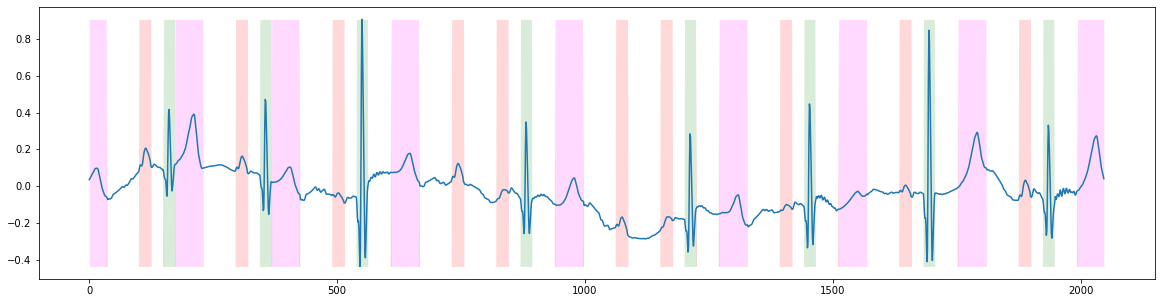

In [539]:
# %%timeit
N = 2048

# Hyperparams
noise = 0.005
size = 500
onset = np.random.randint(0,50)
begining_wave = np.random.randint(0,6)
global_amplitude = 1.+(np.random.randn(1)*0.2)
interp_length = 1.+(np.random.randn(1)*0.2)
doesnt_have_P = (np.random.rand(1) > (1-0.25))
doesnt_have_PQ = (np.random.rand(1) > (1-0.15))
doesnt_have_ST = (np.random.rand(1) > (1-0.15))
has_BBB = (np.random.rand(1) > (1-0.1))
has_TV = (np.random.rand(1) > (1-0.05))
has_same_morph = (np.random.rand(1) > (1-0.2))
proba_P = 0.15
proba_PQ = 0.15
proba_QRS = 0.01
proba_ST = 0.15

##### Data structure
ids = []

##### Identifiers
if not has_same_morph:
    id_P = np.random.randint(0,len(Psignal),size=size)
    id_PQ = np.random.randint(0,len(PQsignal),size=size)
    id_QRS = np.random.randint(0,len(QRSsignal),size=size)
    id_ST = np.random.randint(0,len(STsignal),size=size)
    id_T = np.random.randint(0,len(Tsignal),size=size)
    id_TP = np.random.randint(0,len(TPsignal),size=size)
else:
    id_P = np.repeat(np.random.randint(0,len(Psignal),size=1),size)
    id_PQ = np.repeat(np.random.randint(0,len(PQsignal),size=1),size)
    id_QRS = np.repeat(np.random.randint(0,len(QRSsignal),size=1),size)
    id_ST = np.repeat(np.random.randint(0,len(STsignal),size=1),size)
    id_T = np.repeat(np.random.randint(0,len(Tsignal),size=1),size)
    id_TP = np.repeat(np.random.randint(0,len(TPsignal),size=1),size)
    
# In case QRS is not expressed
filt_QRS = np.random.rand(size) > (1-proba_QRS)

# Except waves
id_P[(np.random.rand(size) > (1-proba_P)) | has_P | has_TV] = -1
id_PQ[filt_QRS | (np.random.rand(size) > (1-proba_PQ)) | has_PQ | has_TV] = -1
id_QRS[filt_QRS] = -1
id_ST[filt_QRS | (np.random.rand(size) > (1-proba_ST)) | has_ST] = -1
id_T[filt_QRS] = -1
id_TP[np.full((size),has_TV,dtype=bool)] = -1

beats = []
masks = []
ids = []
offset = 0
record_size = 0
mark_break = False
for i in range(size):
    for j in range(6):
        if (i == 0) and (j < begining_wave): 
            continue
        if (j == 0) and (id_P[i] != -1):
            amplitude = Pdist.rvs(1)
            segment = trailonset(amplitude*Psignal[Pkeys[id_P[i]]],offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.full((beats[-1].size,),1,dtype='int8'))
            ids.append(('P',Pkeys[id_P[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 1) and (id_PQ[i] != -1):
            amplitude = PQdist.rvs(1)
            segment = trailonset(amplitude*PQsignal[PQkeys[id_PQ[i]]],offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('PQ',PQkeys[id_PQ[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 2) and (id_QRS[i] != -1):
            amplitude = QRSdist.rvs(1)
#             amplitude = 0.15*np.random.randn(1)+1.05
            segment = trailonset(amplitude*QRSsignal[QRSkeys[id_QRS[i]]],offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.full((beats[-1].size,),2,dtype='int8'))
            ids.append(('QRS',QRSkeys[id_QRS[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 3) and (id_ST[i] != -1):
            if has_TV:
                nx = np.random.randint(16)
                if nx < 2:
                    continue
                stsegment = np.convolve(np.cumsum(norm.rvs(scale=0.01**(2*0.5),size=nx)),np.hamming(nx)/(nx//2),mode='same')
            else:
                stsegment = STsignal[STkeys[id_ST[i]]]
            amplitude = STdist.rvs(1)
            segment = trailonset(amplitude*stsegment,offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('ST',STkeys[id_ST[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 4) and (id_T[i] != -1):
            amplitude = Tdist.rvs(1)
            segment = trailonset(amplitude*Tsignal[Tkeys[id_T[i]]],offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.full((beats[-1].size,),3,dtype='int8'))
            ids.append(('T',Tkeys[id_T[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 5) and (id_TP[i] != -1):
            amplitude = TPdist.rvs(1)
            segment = trailonset(amplitude*TPsignal[TPkeys[id_TP[i]]],offset)
            segment_noise = ((0.15*np.random.randn(1))+1)
            segment *= segment_noise
            beats.append(segment)
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('TP',TPkeys[id_TP[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (math.floor(record_size*interp_length)-onset) >= N:
            mark_break = True
            break
    if mark_break:
        break
        
# Obtain final stuff
signal = np.concatenate(beats)
masks = np.concatenate(masks)

# Interpolate signal & mask
x = np.linspace(0,1,signal.size)
signal = sp.interpolate.interp1d(x,signal)(np.linspace(0,1,math.ceil(signal.size*interp_length)))
masks = sp.interpolate.interp1d(x,masks)(np.linspace(0,1,math.ceil(masks.size*interp_length))).astype(int)

# Move onset
signal = signal[onset:onset+N]*global_amplitude
masks = masks[onset:onset+N]

# Retrieve masks
masks_all = np.zeros((N,3),dtype=bool)
masks_all[:,0] = (masks == 1)
masks_all[:,1] = (masks == 2)
masks_all[:,2] = (masks == 3)

# Add baseline wander
w = 51
signal = signal + np.convolve(np.cumsum(norm.rvs(scale=0.01**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

# Plotting
mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

plt.figure(figsize=(20,5))
plt.plot(signal)
plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

In [540]:
P = utils.pickleload(os.path.join('.','pickle','Psignal.pkl'))
PQ = utils.pickleload(os.path.join('.','pickle','PQsignal.pkl'))
QRS = utils.pickleload(os.path.join('.','pickle','QRSsignal.pkl'))
ST = utils.pickleload(os.path.join('.','pickle','STsignal.pkl'))
T = utils.pickleload(os.path.join('.','pickle','Tsignal.pkl'))
TP = utils.pickleload(os.path.join('.','pickle','TPsignal.pkl'))

In [541]:
metric = np.max

amplitudes = {k.split('###')[0]: [] for k in list(QRS)}
for k in QRS:
    g = k.split('###')[0]
    segment = utils.signal.on_off_correction(QRS[k])
    amplitudes[g].append(np.max(segment) - np.min(segment))

In [542]:
Pamplitudes = []
for k in P:
    segment = utils.signal.on_off_correction(P[k])/metric(amplitudes[k.split('###')[0]])
    Pamplitudes.append(segment.max()-segment.min())
Pamplitudes = np.array(Pamplitudes)
PQamplitudes = []
for k in PQ:
    segment = utils.signal.on_off_correction(PQ[k])/metric(amplitudes[k.split('###')[0]])
    PQamplitudes.append(segment.max()-segment.min())
PQamplitudes = np.array(PQamplitudes)
QRSamplitudes = []
for k in QRS:
    segment = utils.signal.on_off_correction(QRS[k])/metric(amplitudes[k.split('###')[0]])
    QRSamplitudes.append(segment.max()-segment.min())
QRSamplitudes = np.array(QRSamplitudes)
STamplitudes = []
for k in ST:
    segment = utils.signal.on_off_correction(ST[k])/metric(amplitudes[k.split('###')[0]])
    STamplitudes.append(segment.max()-segment.min())
STamplitudes = np.array(STamplitudes)
Tamplitudes = []
for k in T:
    segment = utils.signal.on_off_correction(T[k])/metric(amplitudes[k.split('###')[0]])
    Tamplitudes.append(segment.max()-segment.min())
Tamplitudes = np.array(Tamplitudes)
TPamplitudes = []
for k in TP:
    segment = utils.signal.on_off_correction(TP[k])/metric(amplitudes[k.split('###')[0]])
    TPamplitudes.append(segment.max()-segment.min())
TPamplitudes = np.array(TPamplitudes)

In [543]:
Pamplitudes = lognorm(*lognorm.fit(Pamplitudes))
PQamplitudes = lognorm(*lognorm.fit(PQamplitudes[PQamplitudes<0.3]))
QRSamplitudes = lognorm(*lognorm.fit(QRSamplitudes))
STamplitudes = lognorm(*lognorm.fit(STamplitudes))
Tamplitudes = lognorm(*lognorm.fit(Tamplitudes[(Tamplitudes>0.05) & (Tamplitudes<0.5)]))
TPamplitudes = lognorm(*lognorm.fit(TPamplitudes[TPamplitudes<0.4]))

In [544]:
for k in list(P.keys()):
    segment = utils.signal.on_off_correction(P[k])
    P[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(P[k])) or np.any(np.isnan(P[k])):
        P.pop(k)
for k in list(PQ.keys()):
    segment = utils.signal.on_off_correction(PQ[k])
    PQ[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(PQ[k])) or np.any(np.isnan(PQ[k])):
        PQ.pop(k)
for k in list(QRS.keys()):
    segment = utils.signal.on_off_correction(QRS[k])
    QRS[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(QRS[k])) or np.any(np.isnan(QRS[k])):
        QRS.pop(k)
for k in list(ST.keys()):
    segment = utils.signal.on_off_correction(ST[k])
    ST[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(ST[k])) or np.any(np.isnan(ST[k])):
        ST.pop(k)
for k in list(T.keys()):
    segment = utils.signal.on_off_correction(T[k])
    T[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(T[k])) or np.any(np.isnan(T[k])):
        T.pop(k)
for k in list(TP.keys()):
    segment = utils.signal.on_off_correction(TP[k])
    TP[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(TP[k])) or np.any(np.isnan(TP[k])):
        TP.pop(k)

<ipython-input-544-0e724456727d>:8: RuntimeWarning: invalid value encountered in true_divide
  PQ[k] = segment/(np.max(segment)-np.min(segment))
<ipython-input-544-0e724456727d>:18: RuntimeWarning: invalid value encountered in true_divide
  ST[k] = segment/(np.max(segment)-np.min(segment))


In [546]:
import src.data2

In [618]:
dataset = src.data2.Dataset(P, QRS, T, PQ, ST, TP, 
                           Pamplitudes, QRSamplitudes, Tamplitudes, PQamplitudes, 
                           STamplitudes, TPamplitudes, 200*20,proba_TV=0.9,
                           labels_as_masks=True)


In [665]:
%%timeit
x,y = dataset[0]

11 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


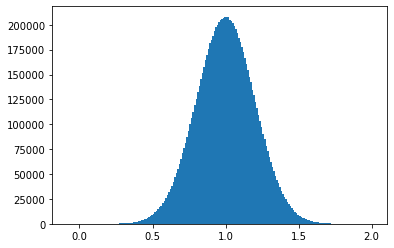

In [726]:
_=plt.hist(np.random.randn(10000000)*0.20+1,bins=200)

In [725]:
(np.random.randn(10000000)*0.20+1).min()

-0.040555127153176995

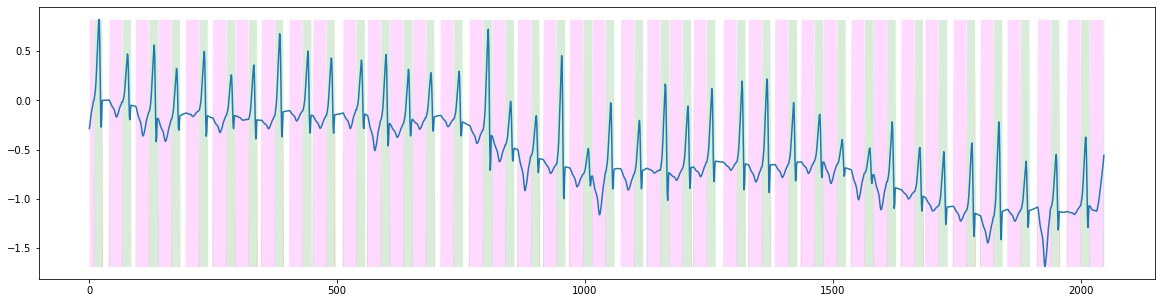

In [709]:
x,y = dataset[0]

# Plotting
mskplt = ((np.max(x)-np.min(x))*y)+np.min(x)

plt.figure(figsize=(20,5))
plt.plot(x.squeeze())
plt.gca().fill_between(np.arange(N), mskplt[0,:], mskplt[0,:].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[1,:], mskplt[1,:].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[2,:], mskplt[2,:].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

In [507]:
np.logical_not(has_P)

array([ True])

In [355]:
has_TV = np.array([True])

In [357]:
np.full((size),has_TV,dtype=bool)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [331]:
id_P[(np.random.rand(size) < proba_P) | np.logical_not(has_P) | has_TV] = -1


In [332]:
id_P

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [314]:
np.logical_not(has_TV)

array([False])

In [295]:
id_P

array([17688, 17688, 17688, 17688, 17688, 17688, 17688,    -1, 17688,
       17688, 17688, 17688, 17688, 17688, 17688, 17688, 17688, 17688,
       17688, 17688, 17688, 17688,    -1, 17688, 17688, 17688,    -1,
       17688, 17688, 17688,    -1, 17688, 17688, 17688,    -1, 17688,
          -1, 17688, 17688, 17688, 17688, 17688, 17688, 17688, 17688,
          -1, 17688, 17688, 17688, 17688, 17688, 17688,    -1, 17688,
       17688, 17688, 17688, 17688, 17688, 17688, 17688, 17688, 17688,
       17688,    -1, 17688, 17688, 17688, 17688, 17688, 17688, 17688,
       17688, 17688, 17688, 17688,    -1, 17688, 17688, 17688, 17688,
       17688, 17688, 17688,    -1, 17688, 17688, 17688, 17688,    -1,
       17688, 17688, 17688, 17688, 17688, 17688, 17688, 17688, 17688,
       17688, 17688, 17688, 17688, 17688, 17688, 17688, 17688, 17688,
          -1, 17688, 17688,    -1, 17688, 17688, 17688, 17688, 17688,
       17688, 17688, 17688, 17688, 17688, 17688, 17688,    -1, 17688,
       17688, 17688,

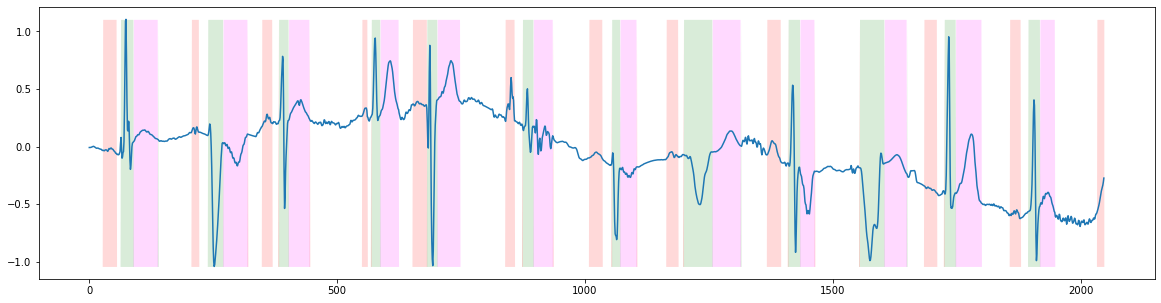

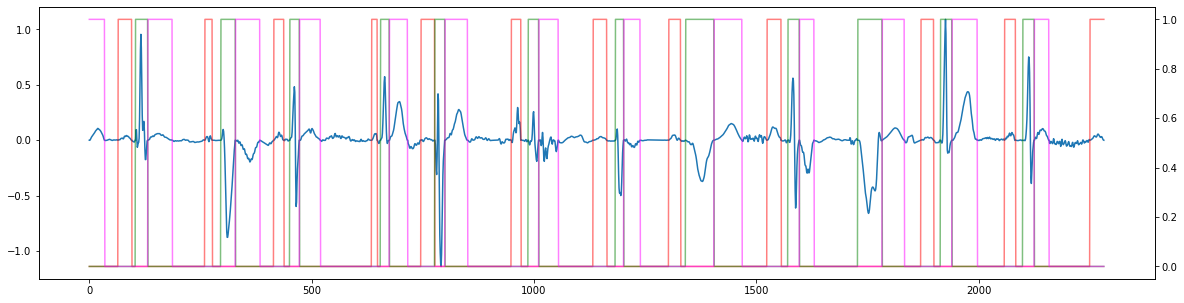

In [109]:
plt.figure(figsize=(20,5))
plt.plot(signal)
plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()
plt.figure(figsize=(20,5))
plt.plot(signal_pre)
plt.twinx()
plt.plot(masks_pre == 1,alpha=0.5,color='red')
plt.plot(masks_pre == 2,alpha=0.5,color='green')
plt.plot(masks_pre == 3,alpha=0.5,color='magenta')
plt.show()

# Boundary Loss

In [139]:
# %%timeit
Pbound = skimage.segmentation.find_boundaries(tns[:,0,None])
QRSbound = skimage.segmentation.find_boundaries(tns[:,1,None])
Tbound = skimage.segmentation.find_boundaries(tns[:,2,None])

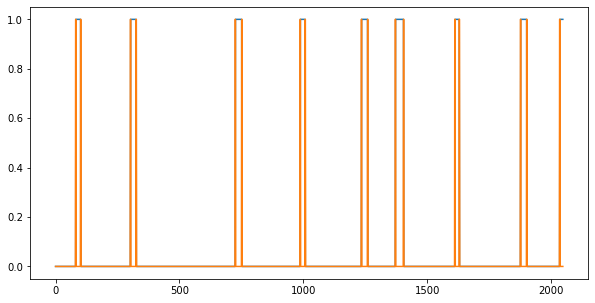

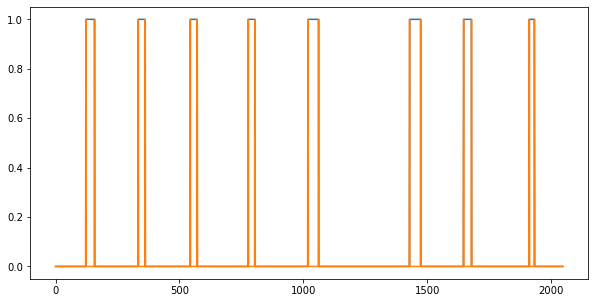

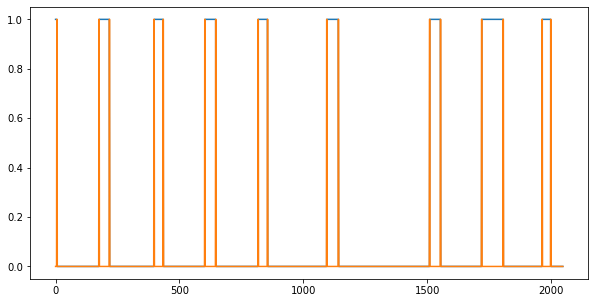

In [143]:
plt.figure(figsize=(10,5))
plt.plot(tns[:,0])
plt.plot(Pbound.squeeze())
plt.figure(figsize=(10,5))
plt.plot(tns[:,1])
plt.plot(QRSbound.squeeze())
plt.figure(figsize=(10,5))
plt.plot(tns[:,2])
plt.plot(Tbound.squeeze())

In [ ]:
torch.zeros()

# Generate recording

In [72]:
Pkeys = list(Psignal.keys())
PQkeys = list(PQsignal.keys())
QRSkeys = list(QRSsignal.keys())
STkeys = list(STsignal.keys())
Tkeys = list(Tsignal.keys())
TPkeys = list(TPsignal.keys())

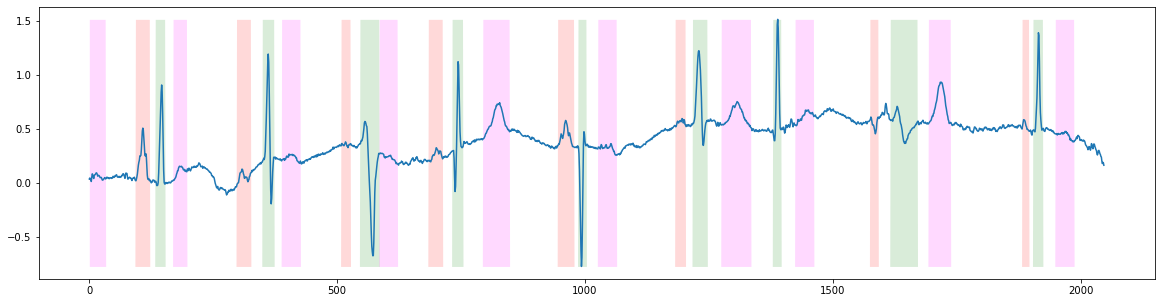

In [172]:
# %%timeit
N = 2048

# Hyperparams
noise = 0.005
size = 100
onset = np.random.randint(0,50)
begining_wave = np.random.randint(0,6)
has_P = (np.random.rand(1) > 0.25)
has_PQ = (np.random.rand(1) > 0.15)
has_ST = (np.random.rand(1) > 0.25)
has_BBB = (np.random.rand(1) > 0.9)
has_same_morph = (np.random.rand(1) > 0.5)
proba_P = 0.15
proba_PQ = 0.15
proba_QRS = 0.01
proba_ST = 0.15

##### Data structure
ids = []

##### Identifiers
if not has_same_morph:
    id_P = np.random.randint(0,len(Psignal),size=size)
    id_PQ = np.random.randint(0,len(PQsignal),size=size)
    id_QRS = np.random.randint(0,len(QRSsignal),size=size)
    id_ST = np.random.randint(0,len(STsignal),size=size)
    id_T = np.random.randint(0,len(Tsignal),size=size)
    id_TP = np.random.randint(0,len(TPsignal),size=size)
else:
    id_P = np.repeat(np.random.randint(0,len(Psignal),size=1),size)
    id_PQ = np.repeat(np.random.randint(0,len(PQsignal),size=1),size)
    id_QRS = np.repeat(np.random.randint(0,len(QRSsignal),size=1),size)
    id_ST = np.repeat(np.random.randint(0,len(STsignal),size=1),size)
    id_T = np.repeat(np.random.randint(0,len(Tsignal),size=1),size)
    id_TP = np.repeat(np.random.randint(0,len(TPsignal),size=1),size)
    
# In case QRS is not expressed
filt_QRS = np.random.rand(size) < proba_QRS

# P wave
id_P[(np.random.rand(size) < proba_P) | np.logical_not(has_P)] = -1
id_PQ[filt_QRS | (np.random.rand(size) < proba_PQ) | np.logical_not(has_PQ)] = -1
id_QRS[filt_QRS] = -1
id_ST[filt_QRS | (np.random.rand(size) < proba_ST) | np.logical_not(has_ST)] = -1
id_T[filt_QRS] = -1

beats = []
masks = []
ids = []
offset = 0
record_size = 0
mark_break = False
for i in range(size):
    for j in range(6):
        if (i == 0) and (j < begining_wave): 
            continue
        if (j == 0) and (id_P[i] != -1):
            segment = trailonset(Psignal[Pkeys[id_P[i]]],offset)
            segment = segment*((0.15*np.random.randn(1))+1)
            segment += noise*np.random.randn(segment.size)
            beats.append(segment)
            masks.append(np.full((beats[-1].size,),1,dtype='int8'))
            ids.append(('P',Pkeys[id_P[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 1) and (id_PQ[i] != -1):
            segment = trailonset(PQsignal[PQkeys[id_PQ[i]]],offset)
            segment = segment*((0.15*np.random.randn(1))+1)
            segment += noise*np.random.randn(segment.size)
            beats.append(segment)
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('PQ',PQkeys[id_PQ[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 2) and (id_QRS[i] != -1):
            segment = trailonset(QRSsignal[QRSkeys[id_QRS[i]]],offset)
            segment = segment*((0.15*np.random.randn(1))+1)
            segment += noise*np.random.randn(segment.size)
            beats.append(segment)
            masks.append(np.full((beats[-1].size,),2,dtype='int8'))
            ids.append(('QRS',QRSkeys[id_QRS[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 3) and (id_ST[i] != -1):
            segment = trailonset(STsignal[STkeys[id_ST[i]]],offset)
            segment = segment*((0.15*np.random.randn(1))+1)
            segment += noise*np.random.randn(segment.size)
            beats.append(segment)
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('ST',STkeys[id_ST[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 4) and (id_T[i] != -1):
            segment = trailonset(Tsignal[Tkeys[id_T[i]]],offset)
            segment = segment*((0.15*np.random.randn(1))+1)
            segment += noise*np.random.randn(segment.size)
            beats.append(segment)
            masks.append(np.full((beats[-1].size,),3,dtype='int8'))
            ids.append(('T',Tkeys[id_T[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 5) and (id_TP[i] != -1):
            segment = trailonset(TPsignal[TPkeys[id_TP[i]]],offset)
            segment = segment*((0.15*np.random.randn(1))+1)
            segment += noise*np.random.randn(segment.size)
            beats.append(segment)
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('TP',TPkeys[id_TP[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (record_size-onset) >= N:
            mark_break = True
            break
    if mark_break:
        break
        
# Obtain final stuff
signal = np.concatenate(beats)
masks = np.concatenate(masks)
masks_all = np.zeros((record_size,3),dtype=bool)
masks_all[:,0] = (masks == 1)
masks_all[:,1] = (masks == 2)
masks_all[:,2] = (masks == 3)

# Move onset
signal = signal[onset:onset+N]
masks_all = masks_all[onset:onset+N,:]

# Add baseline wander
w = 51
signal = signal + np.convolve(np.cumsum(norm.rvs(scale=0.01**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

# Plotting
mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

plt.figure(figsize=(20,5))
plt.plot(signal)
plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

In [143]:
ids

[('QRS', '28_III###0'),
 ('T', '114_V6###12'),
 ('TP', '136_V5###0'),
 ('PQ', '142_V1###5'),
 ('QRS', '138_V2###2'),
 ('ST', '96_V2###2'),
 ('T', 'sel33_1###1'),
 ('TP', '7_V6###0'),
 ('P', '196_V3###7'),
 ('PQ', 'sel873_1###14'),
 ('QRS', '42_AVL###6'),
 ('ST', '68_AVL###1'),
 ('T', '77_AVL###5'),
 ('TP', 'sele0126_1###0'),
 ('P', '39_V5###0'),
 ('PQ', 'sel213_0###17'),
 ('QRS', '136-1-1###V3'),
 ('ST', 'sel123_1###0'),
 ('T', '191_II###0'),
 ('TP', '17_II###7'),
 ('P', '131_AVR###5'),
 ('QRS', '393-1-1###II'),
 ('T', '158_V2###0'),
 ('TP', '85_V4###8'),
 ('P', '84_V5###0'),
 ('PQ', '62_V2###0'),
 ('QRS', '108_AVF###1'),
 ('T', '86_V1###3'),
 ('TP', '79_III###1'),
 ('P', '133_V3###0'),
 ('PQ', 'sel871_1###10'),
 ('QRS', '95_V5###0'),
 ('ST', 'sele0406_1###0'),
 ('T', '103_AVL###1'),
 ('TP', '180_III###7'),
 ('P', '92_V6###10'),
 ('PQ', '114_V2###0'),
 ('QRS', '119-1-1###V4'),
 ('ST', '152_AVF###3'),
 ('T', '190_III###0'),
 ('TP', '61_AVR###6'),
 ('P', '154_III###7'),
 ('PQ', '124_I###

In [153]:
plt.plot(QRSsignal['95_II###0'])

KeyError: '95_II###0'

# Define signal generator

In [174]:
mskplt.shape

(2048, 3)

In [220]:
class Dataset(torch.utils.data.Dataset):
    '''Generates data for PyTorch'''

    def __init__(self, P, QRS, T, PQ, ST, TP, 
                 Pamplitudes, QRSamplitudes, Tamplitudes, 
                 PQamplitudes, STamplitudes, TPamplitudes, 
                 length,N = 2048, noise = 0.005, size = 100, 
                 proba_P = 0.25,proba_QRS = 0.01, proba_PQ = 0.15, 
                 proba_ST = 0.15, proba_same_morph = 0.5,
                 add_baseline_wander = True, window = 51):
        # Segments
        self.P = P
        self.QRS = QRS
        self.T = T
        self.PQ = PQ
        self.ST = ST
        self.TP = TP
        self.Pamplitudes = Pamplitudes
        self.QRSamplitudes = QRSamplitudes
        self.Tamplitudes = Tamplitudes
        self.PQamplitudes = PQamplitudes
        self.STamplitudes = STamplitudes
        self.TPamplitudes = TPamplitudes
        self.Pkeys = list(P.keys())
        self.QRSkeys = list(QRS.keys())
        self.Tkeys = list(T.keys())
        self.PQkeys = list(PQ.keys())
        self.STkeys = list(ST.keys())
        self.TPkeys = list(TP.keys())
        
        # Generation hyperparams
        self.length = length
        self.N = N
        self.noise = noise
        self.size = size
        self.add_baseline_wander = add_baseline_wander
        self.window = window

        # Probabilities
        self.proba_P = proba_P
        self.proba_QRS = proba_QRS
        self.proba_PQ = proba_PQ
        self.proba_ST = proba_ST
        self.proba_same_morph = proba_same_morph
        
        
    def __len__(self):
        '''Denotes the number of elements in the dataset'''
        return self.length

    def __getitem__(self, i: int):
        '''Generates one datapoint''' 
        onset = np.random.randint(0,50)
        begining_wave = np.random.randint(0,6)
        has_P = (np.random.rand(1) > self.proba_P)
        has_PQ = (np.random.rand(1) > self.proba_PQ)
        has_ST = (np.random.rand(1) > self.proba_ST)
        has_same_morph = (np.random.rand(1) > self.proba_same_morph)

        ##### Data structure
        ids = []

        ##### Identifiers
        if not has_same_morph:
            id_P = np.random.randint(0,len(self.P),size=self.size)
            id_PQ = np.random.randint(0,len(self.PQ),size=self.size)
            id_QRS = np.random.randint(0,len(self.QRS),size=self.size)
            id_ST = np.random.randint(0,len(self.ST),size=self.size)
            id_T = np.random.randint(0,len(self.T),size=self.size)
            id_TP = np.random.randint(0,len(self.TP),size=self.size)
        else:
            id_P = np.repeat(np.random.randint(0,len(self.P),size=1),self.size)
            id_PQ = np.repeat(np.random.randint(0,len(self.PQ),size=1),self.size)
            id_QRS = np.repeat(np.random.randint(0,len(self.QRS),size=1),self.size)
            id_ST = np.repeat(np.random.randint(0,len(self.ST),size=1),self.size)
            id_T = np.repeat(np.random.randint(0,len(self.T),size=1),self.size)
            id_TP = np.repeat(np.random.randint(0,len(self.TP),size=1),self.size)

        # In case QRS is not expressed
        filt_QRS = np.random.rand(self.size) < self.proba_QRS

        # P wave
        id_P[(np.random.rand(self.size) < self.proba_P) | np.logical_not(has_P)] = -1
        id_PQ[filt_QRS | (np.random.rand(self.size) < self.proba_PQ) | np.logical_not(has_PQ)] = -1
        id_QRS[filt_QRS] = -1
        id_ST[filt_QRS | (np.random.rand(self.size) < self.proba_ST) | np.logical_not(has_ST)] = -1
        id_T[filt_QRS] = -1

        beats = []
        masks = []
        ids = []
        offset = 0
        record_size = 0
        mark_break = False
        for i in range(self.size):
            for j in range(6):
                if (i == 0) and (j < begining_wave): 
                    continue
                if (j == 0) and (id_P[i] != -1):
                    amplitude = self.Pamplitudes.rvs(1)
                    segment = trailonset(amplitude*self.P[self.Pkeys[id_P[i]]],offset)
                    segment *= 0.15*np.random.randn(1)+1
                    beats.append(segment)
                    masks.append(np.full((beats[-1].size,),1,dtype='int8'))
                    ids.append(('P',self.Pkeys[id_P[i]]))
                    offset = beats[-1][-1]
                    record_size += beats[-1].size
                if (j == 1) and (id_PQ[i] != -1):
                    amplitude = self.PQamplitudes.rvs(1)
                    segment = trailonset(amplitude*self.PQ[self.PQkeys[id_PQ[i]]],offset)
                    segment *= 0.15*np.random.randn(1)+1
                    beats.append(segment)
                    masks.append(np.zeros((beats[-1].size,),dtype='int8'))
                    ids.append(('PQ',self.PQkeys[id_PQ[i]]))
                    offset = beats[-1][-1]
                    record_size += beats[-1].size
                if (j == 2) and (id_QRS[i] != -1):
                    amplitude = self.QRSamplitudes.rvs(1)
                    segment = trailonset(amplitude*self.QRS[self.QRSkeys[id_QRS[i]]],offset)
                    segment *= 0.15*np.random.randn(1)+1
                    beats.append(segment)
                    masks.append(np.full((beats[-1].size,),2,dtype='int8'))
                    ids.append(('QRS',self.QRSkeys[id_QRS[i]]))
                    offset = beats[-1][-1]
                    record_size += beats[-1].size
                if (j == 3) and (id_ST[i] != -1):
                    amplitude = self.STamplitudes.rvs(1)
                    segment = trailonset(amplitude*self.ST[self.STkeys[id_ST[i]]],offset)
                    segment *= 0.15*np.random.randn(1)+1
                    beats.append(segment)
                    masks.append(np.zeros((beats[-1].size,),dtype='int8'))
                    ids.append(('ST',self.STkeys[id_ST[i]]))
                    offset = beats[-1][-1]
                    record_size += beats[-1].size
                if (j == 4) and (id_T[i] != -1):
                    amplitude = self.Tamplitudes.rvs(1)
                    segment = trailonset(amplitude*self.T[self.Tkeys[id_T[i]]],offset)
                    segment *= 0.15*np.random.randn(1)+1
                    beats.append(segment)
                    masks.append(np.full((beats[-1].size,),3,dtype='int8'))
                    ids.append(('T',self.Tkeys[id_T[i]]))
                    offset = beats[-1][-1]
                    record_size += beats[-1].size
                if (j == 5) and (id_TP[i] != -1):
                    amplitude = self.TPamplitudes.rvs(1)
                    segment = trailonset(amplitude*self.TP[self.TPkeys[id_TP[i]]],offset)
                    segment *= 0.15*np.random.randn(1)+1
                    beats.append(segment)
                    masks.append(np.zeros((beats[-1].size,),dtype='int8'))
                    ids.append(('TP',self.TPkeys[id_TP[i]]))
                    offset = beats[-1][-1]
                    record_size += beats[-1].size
                if (record_size-onset) >= N:
                    mark_break = True
                    break
            if mark_break:
                break

        # Obtain final stuff
        signal = np.concatenate(beats,)
        masks = np.concatenate(masks)
        masks_all = np.zeros((3,record_size),dtype=bool)
        masks_all[0,:] = (masks == 1)
        masks_all[1,:] = (masks == 2)
        masks_all[2,:] = (masks == 3)

        # Move onset
        signal = signal[onset:onset+N]
        masks_all = masks_all[:,onset:onset+N]

        # Add baseline wander
        if self.add_baseline_wander:
            signal = signal + np.convolve(np.cumsum(norm.rvs(scale=0.01**(2*0.5),size=N)),np.hamming(self.window)/(self.window/2),mode='same')
        
        return signal[None,].astype('float32'), masks_all


In [222]:
data = Dataset(Psignal,QRSsignal,Tsignal,PQsignal,STsignal,TPsignal,Pdist,QRSdist,Tdist,PQdist,STdist,TPdist,256*200)

# %%timeit
# x,y = data[0]

In [227]:
# %%timeit

loader = torch.utils.data.DataLoader(data,256)

for x,y in loader:
    break

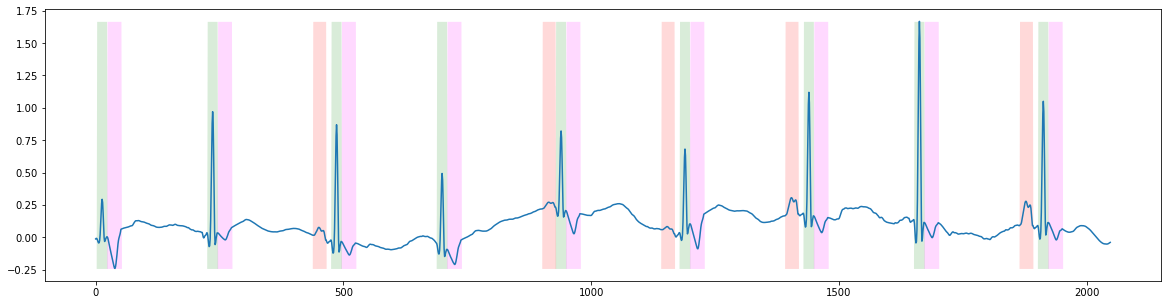

In [253]:
# Plotting
i = 160
mskplt = ((torch.max(x[i,0,:])-torch.min(x[i,0,:]))*y[i,...])+torch.min(x[i,0,:])

plt.figure(figsize=(20,5))
plt.plot(x[i,0,:])
plt.gca().fill_between(np.arange(N), mskplt[0,:], mskplt[0,:].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[1,:], mskplt[1,:].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[2,:], mskplt[2,:].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

In [ ]:
# i = 103
# lead = 'iii'
# rec = wfdb.rdrecord(os.path.join(basedir,'ludb','{}'.format(i)))
# ann = wfdb.rdann(os.path.join(basedir,'ludb','{}'.format(i)),'atr_{}'.format(lead.lower()))
# print(np.array(ann.symbol))
# wfdb.plot.plot_wfdb(record=rec, annotation=ann, figsize=(20,40))

# fiducials to delete

* QRS - 111_AVF_24
* QRS - sel820_1_156
* QRS - 95_AVR_16
* ~TP - sel306_1_211~
* ~TP - sel114_0_179~
* PT - sel803_0_109

# OLD AND CREEPY

#### Compute criteria

In [ ]:
# # Generate wavelets
# Pwavelet = {k: utils.wavelet.transform(Psignal[k],250.).squeeze() for k in tqdm.tqdm(Psignal.keys())}
# PQwavelet = {k: utils.wavelet.transform(PQsignal[k],250.).squeeze() for k in tqdm.tqdm(PQsignal.keys())}
# QRSwavelet = {k: utils.wavelet.transform(QRSsignal[k],250.).squeeze() for k in tqdm.tqdm(QRSsignal.keys())}
# STwavelet = {k: utils.wavelet.transform(STsignal[k],250.).squeeze() for k in tqdm.tqdm(STsignal.keys())}
# Twavelet = {k: utils.wavelet.transform(Tsignal[k],250.).squeeze() for k in tqdm.tqdm(Tsignal.keys())}
# TPwavelet = {k: utils.wavelet.transform(TPsignal[k],250.).squeeze() for k in tqdm.tqdm(TPsignal.keys())}

In [ ]:
# # Generate criteria
# s = 3 # wavelet scale
# eps = np.finfo('float').eps
# Pcriteria = {k: ((np.sign(Pwavelet[k][0,s]),(Pwavelet[k][0,s]-Pwavelet[k][1,s]+eps)/(np.max(Pwavelet[k][:,s])-np.min(Pwavelet[k][:,s]+eps))),
#                  (np.sign(Pwavelet[k][-1,s]),(Pwavelet[k][-1,s]-Pwavelet[k][-2,s]+eps)/(np.max(Pwavelet[k][:,s])-np.min(Pwavelet[k][:,s]+eps)))) for k in Psignal.keys()}
# PQcriteria = {k: ((np.sign(PQwavelet[k][0,s]),(PQwavelet[k][0,s]-PQwavelet[k][1,s]+eps)/(np.max(PQwavelet[k][:,s])-np.min(PQwavelet[k][:,s]+eps))),
#                  (np.sign(PQwavelet[k][-1,s]),(PQwavelet[k][-1,s]-PQwavelet[k][-2,s]+eps)/(np.max(PQwavelet[k][:,s])-np.min(PQwavelet[k][:,s]+eps)))) for k in PQsignal.keys()}
# QRScriteria = {k: ((np.sign(QRSwavelet[k][0,s]),(QRSwavelet[k][0,s]-QRSwavelet[k][1,s]+eps)/(np.max(QRSwavelet[k][:,s])-np.min(QRSwavelet[k][:,s]+eps))),
#                  (np.sign(QRSwavelet[k][-1,s]),(QRSwavelet[k][-1,s]-QRSwavelet[k][-2,s]+eps)/(np.max(QRSwavelet[k][:,s])-np.min(QRSwavelet[k][:,s]+eps)))) for k in QRSsignal.keys()}
# STcriteria = {k: ((np.sign(STwavelet[k][0,s]),(STwavelet[k][0,s]-STwavelet[k][1,s]+eps)/(np.max(STwavelet[k][:,s])-np.min(STwavelet[k][:,s]+eps))),
#                  (np.sign(STwavelet[k][-1,s]),(STwavelet[k][-1,s]-STwavelet[k][-2,s]+eps)/(np.max(STwavelet[k][:,s])-np.min(STwavelet[k][:,s]+eps)))) for k in STsignal.keys()}
# Tcriteria = {k: ((np.sign(Twavelet[k][0,s]),(Twavelet[k][0,s]-Twavelet[k][1,s]+eps)/(np.max(Twavelet[k][:,s])-np.min(Twavelet[k][:,s]+eps))),
#                  (np.sign(Twavelet[k][-1,s]),(Twavelet[k][-1,s]-Twavelet[k][-2,s]+eps)/(np.max(Twavelet[k][:,s])-np.min(Twavelet[k][:,s]+eps)))) for k in Tsignal.keys()}
# TPcriteria = {k: ((np.sign(TPwavelet[k][0,s]),(TPwavelet[k][0,s]-TPwavelet[k][1,s]+eps)/(np.max(TPwavelet[k][:,s])-np.min(TPwavelet[k][:,s]+eps))),
#                  (np.sign(TPwavelet[k][-1,s]),(TPwavelet[k][-1,s]-TPwavelet[k][-2,s]+eps)/(np.max(TPwavelet[k][:,s])-np.min(TPwavelet[k][:,s]+eps)))) for k in TPsignal.keys()}

In [ ]:
# N = 2048
# s = 3

# has_P = np.random.rand(1) > 0.1
# has_PQ = np.random.rand(1) > 0.2
# has_ST = np.random.rand(1) > 0.2
# has_BBB = np.random.rand(1) > 0.9
# counter_BBB = 0
# repetitions_BBB = np.random.randint(2,4)

# beats = []
# ids = []

# # Include first beat
# ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
# beats.append(utils.signal.on_off_correction(TPsignal[list(TPsignal)[ids[-1][1]]]))
# size = beats[0].size
# masks = np.zeros((size,),dtype='int8')
# onset = np.random.randint(0,size)
# while size-onset < N:
#     # P wave (sometimes)
#     if has_BBB:
#         if counter_BBB == 0:
#             id_BBB_P = ('Psignal',np.random.randint(0,len(Psignal)))
#         ids.append(id_BBB_P)
#         p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(p)
#         masks = np.concatenate((masks,1*np.ones((p.size,),dtype='int8')))

#         if has_PQ:
#             # PQ segment
#             ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
#             pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(pq)
#             masks = np.concatenate((masks,np.zeros((pq.size,),dtype='int8')))
#     elif (np.random.rand(1) < 0.75) and (has_P):
#         ids.append(('Psignal',np.random.randint(0,len(Psignal))))
#         p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(p)
#         masks = np.concatenate((masks,1*np.ones((p.size,),dtype='int8')))

#         if has_PQ:
#             # PQ segment
#             ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
#             pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(pq)
#             masks = np.concatenate((masks,np.zeros((pq.size,),dtype='int8')))

#     # QRS wave
#     has_QRS = np.random.rand(1)
#     if has_BBB:
#         if counter_BBB%repetitions_BBB == 0:
#             id_BBB_QRS = ('QRSsignal',np.random.randint(0,len(QRSsignal)))
#             ids.append(id_BBB_QRS)
#             qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(qrs)
#             masks = np.concatenate((masks,2*np.ones((qrs.size,),dtype='int8')))
#         else:
#             pass
#     elif (has_QRS < 0.99):
#         ids.append(('QRSsignal',np.random.randint(0,len(QRSsignal))))
#         qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(qrs)
#         masks = np.concatenate((masks,2*np.ones((qrs.size,),dtype='int8')))
    
#     # ST segment
#     if has_BBB and (counter_BBB%repetitions_BBB != 0):
#         pass
#     elif (np.random.rand(1) < 0.75) and (has_ST):
#         ids.append(('STsignal',np.random.randint(0,len(STsignal))))
#         st = trailonset(STsignal[list(STsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(st)
#         masks = np.concatenate((masks,np.zeros((st.size,),dtype='int8')))

#     # T wave
#     if has_BBB:
#         if counter_BBB%repetitions_BBB == 0:
#             ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
#             t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(t)
#             masks = np.concatenate((masks,3*np.ones((t.size,),dtype='int8')))
#         else:
#             pass
#     elif (has_QRS < 0.99):
#         ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
#         t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(t)
#         masks = np.concatenate((masks,3*np.ones((t.size,),dtype='int8')))

#     # TP segment
#     if has_BBB:
#         if counter_BBB == 0:
#             id_BBB_TP = ('TPsignal',np.random.randint(0,len(TPsignal)))
#         ids.append(id_BBB_TP)
#         tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(tp)
#         masks = np.concatenate((masks,np.zeros((tp.size,),dtype='int8')))
#     else:
#         ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
#         tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(tp)
#         masks = np.concatenate((masks,np.zeros((tp.size,),dtype='int8')))
    
#     # Account for total signal size
#     size = sum([beats[i].size for i in range(len(beats))])
        
#     # Update BBB counter
#     if has_BBB:
#         counter_BBB += 1

# sig = np.concatenate(beats)[onset:onset+2048]
# # sig = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250, 'high'),sig)
# signal = sig# + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

# masks = masks[onset:onset+2048]
# masks_all = np.zeros((N,3),dtype=bool)
# masks_all[:,0] = masks == 1
# masks_all[:,1] = masks == 2
# masks_all[:,2] = masks == 3
# mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

# # f,ax = plt.subplots(nrows=1,figsize=(20,4))
# # ax = np.array(ax)
# # if len(ax.shape) == 0: ax = ax[None]
# # [ax[i].set_xlim([0,N]) for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red') for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green') for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta') for i in range(ax.size)]
# # ax[0].plot(signal)
# # # ax[1].plot(wvlts,color='orange')
# # # ax[2].plot(wvlts_signal,color='orange')

In [ ]:
# N = 2048

# beats = []
# ids = []

# # Include first beat
# ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
# beats.append(utils.signal.on_off_correction(TPsignal[list(TPsignal)[ids[-1][1]]]))
# # beats.append(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
# size = beats[0].size
# masks = np.zeros((size,))
# onset = np.random.randint(0,size)
# while size-onset < N:
#     # P wave (sometimes)
#     if np.random.rand(1) < 0.75:
#         # p = utils.signal.on_off_correction(Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]])
#         ids.append(('Psignal',np.random.randint(0,len(Psignal))))
#         p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])
#         # p = Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]]
#         beats.append(p)
#         masks = np.concatenate((masks,1*np.ones((p.size,))))

#     # PQ segment
#     # pq = utils.signal.on_off_correction(PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]])
#     ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
#     pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])
#     # pq = PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]]
#     beats.append(pq)
#     masks = np.concatenate((masks,np.zeros((pq.size,))))

#     # QRS wave
#     # qrs = utils.signal.on_off_correction(QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]])
#     ids.append(('QRSsignal',np.random.randint(0,len(QRSsignal))))
#     qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])
#     # qrs = QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]]
#     beats.append(qrs)
#     masks = np.concatenate((masks,2*np.ones((qrs.size,))))

#     # ST segment
#     # st = utils.signal.on_off_correction(STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]])
#     ids.append(('STsignal',np.random.randint(0,len(STsignal))))
#     st = trailonset(STsignal[list(STsignal)[ids[-1][1]]],beats[-1][-1])
#     # st = STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]]
#     beats.append(st)
#     masks = np.concatenate((masks,np.zeros((st.size,))))

#     # T wave
#     # t = utils.signal.on_off_correction(Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]])
#     ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
#     t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])
#     # t = Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]]
#     beats.append(t)
#     masks = np.concatenate((masks,3*np.ones((t.size,))))

#     # TP segment
#     # tp = utils.signal.on_off_correction(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
#     ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
#     tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])
#     # tp = TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]]
#     beats.append(tp)
#     masks = np.concatenate((masks,np.zeros((tp.size,))))

#     size = sum([beats[i].size for i in range(len(beats))])

# w = 51
# sig = np.concatenate(beats)[onset:onset+2048]
# sig = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250, 'high'),sig)
# signal = sig# + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

# masks = masks[onset:onset+2048]
# masks_all = np.zeros((N,3),dtype=bool)
# masks_all[:,0] = masks == 1
# masks_all[:,1] = masks == 2
# masks_all[:,2] = masks == 3
# mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

# plt.figure(figsize=(20,5))
# plt.plot(signal)
# plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
# plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
# plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
# plt.show()